### Classification on the Census Income Data Set

### Introduction

The goal here is to build a classification model to predict whether a person made above  or below $50,000 a year using the 1994 US census income data. The data include various demographic and socio-economic variables (e.g., age, race, sex, education, marital status, occupation, employment status, hours worked per week, etc), including each respondent's income level (<= 50,000 or > 50,000 USD) in 1994. 

### 1. Inspecting and preprocessing data

In [27]:
#import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#import the census data from the uci machine learning repository. 
file_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age','workclass','fnlwgt','education','education-num','marital-status',
          'occupation','relationship','race','sex','capital-gain','capital-loss',
          'hours-per-week','native-country', 'income']

In [28]:
#read census csv file into a pandas dataframe and print its head.
df = pd.read_csv(file, index_col=False, header=None, names=column_names)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [29]:
#display the info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### EDA

In [30]:
#see some summary statistics of the numerical variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Let's see what ordinal values in 'education-num' means. They should correspond to the values in the 'education' variable.

In [49]:
df.groupby(['education-num', 'education']).size()

education-num  education    
1               Preschool          51
2               1st-4th           168
3               5th-6th           333
4               7th-8th           646
5               9th               514
6               10th              933
7               11th             1175
8               12th              433
9               HS-grad         10501
10              Some-college     7291
11              Assoc-voc        1382
12              Assoc-acdm       1067
13              Bachelors        5355
14              Masters          1723
15              Prof-school       576
16              Doctorate         413
dtype: int64

What are the race categories?

In [51]:
df['race'].value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

Let's visualize each pair of numeric variables with seaborn pair grid. We can add histograms along the diagonal to show the univariate distribution of each numeric variable. Let's also specify income label as the hue argument. 

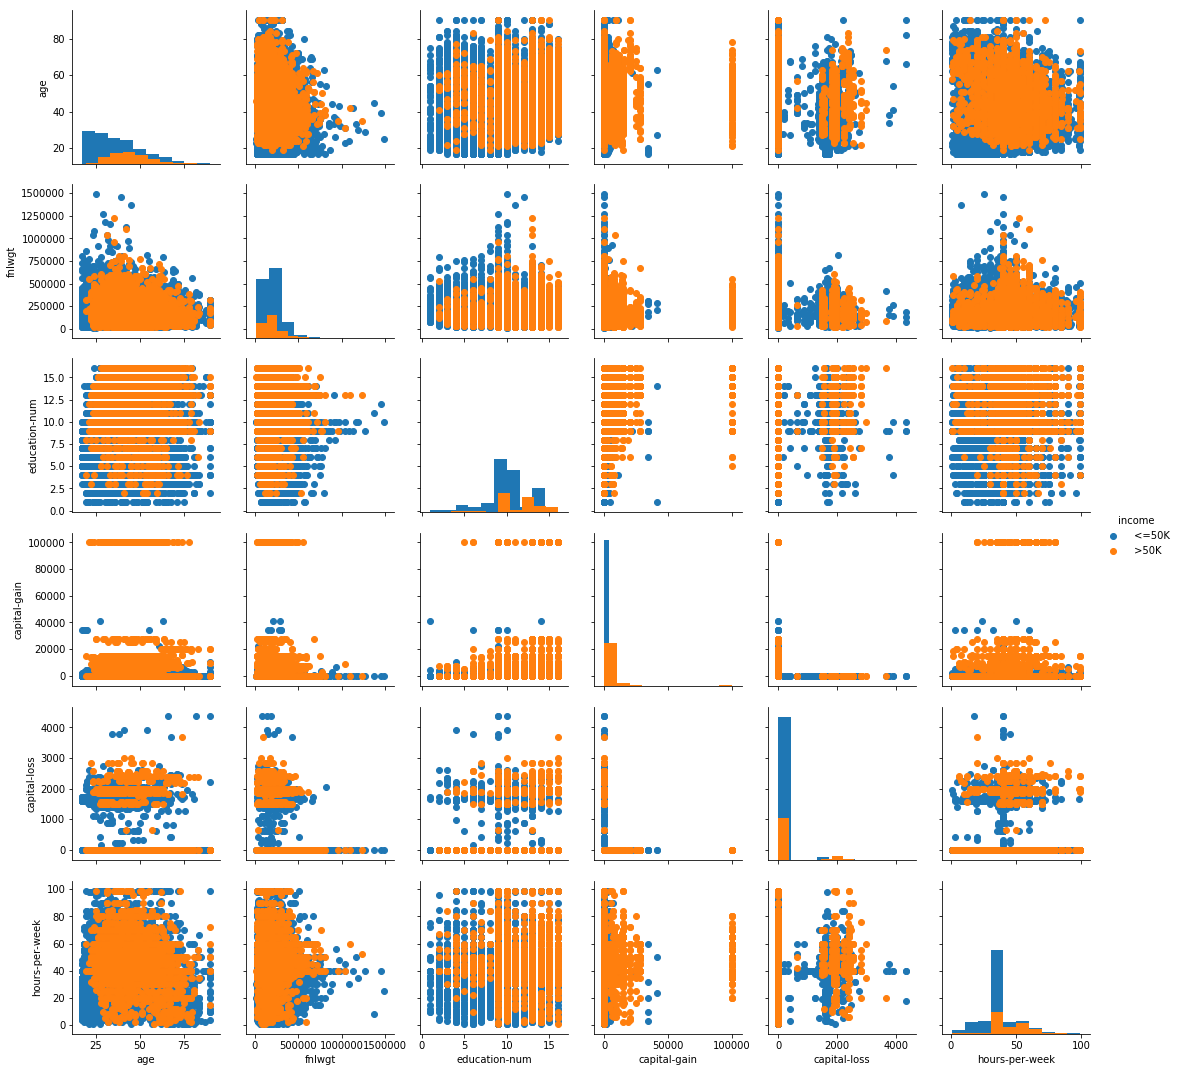

In [50]:
g = sns.PairGrid(df, hue='income')
_ = g.map_diag(plt.hist)
_ = g.map_offdiag(plt.scatter)
_ = g.add_legend()

There seems to be a lot more people who made 50K or less. People who had some college-level education, or higher, were much more likely to earn more than 50K. People who were less 20 years old were unlikely to make more than 50K. 


Let's see the visualize income label on age and education between the two genders.

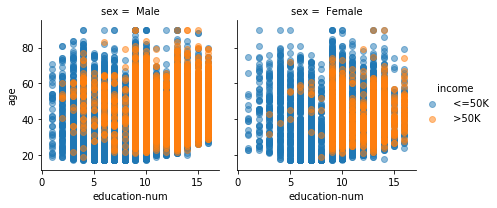

In [56]:
g = sns.FacetGrid(df, col="sex", hue="income")
_ = g.map(plt.scatter, "education-num", "age", alpha=.5)
_ = g.add_legend()

What if we stratify by race

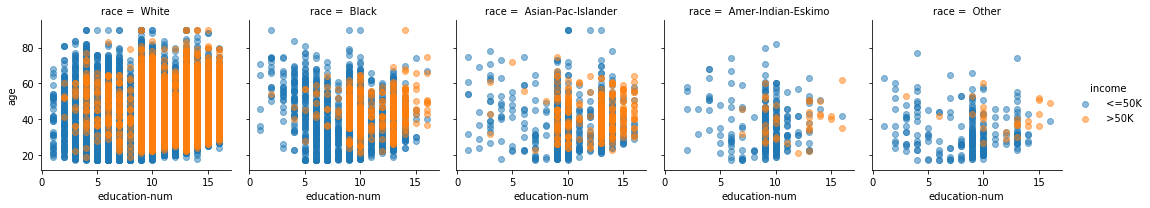

In [57]:
g = sns.FacetGrid(df, col="race", hue="income")
_ = g.map(plt.scatter, "education-num", "age",alpha=.5)
_ = g.add_legend()

#### Preprocessing for classification

Split data into training and test sets. Convert categorical variables to dummy variables, since sklearn require all values to be numeric.  

Standardize data 

### 2. Fitting two classification models

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

K-Nearest Neighbors

### 3. Predict labels for test data